# Introduction to Compucter Vision. Assignment 2

### Alfiya Mussabekova

----------------------------------------

YOLO object detector

## Import libararies

In [ ]:
# all plots will be set directly below the code cell that produced it
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output
# set inline plots size
plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
import numpy as np
import time
import os
import cv2
import zipfile
import tarfile
from collections import namedtuple
from google.colab.patches import cv2_imshow
from xml.dom import minidom

### Download images

In [ ]:
!wget "https://miro.medium.com/max/872/1*EYFejGUjvjPcc4PZTwoufw.jpeg" -O traffic.jpeg
clear_output()

### Download YOLO model

In [ ]:
!wget https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/opencv-yolo/yolo-object-detection.zip?__s=1essnpgyhz7jwwcpjszi -O yolo-object-detection.zip
clear_output()

### Download Pascal dataset

In [ ]:
#unable to get it online, 
#!wget http://mrg.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar -O pascal.tar
#http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar is alternative source, download speed so low, so I will share the required images separately
#!wget http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar -O pascal.tar
!wget 'https://www.dropbox.com/s/qp2s4ubh41km380/2012_000160.jpg?dl=0' -O '2012_000160.jpg'
!wget 'https://www.dropbox.com/s/ctla264cy79bvfg/2012_000160.xml?dl=0' -O '2012_000160.xml'
clear_output()

### Extract model and dataset

In [ ]:
# UNZIP YOLO
with zipfile.ZipFile('yolo-object-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('yolo_data')
    

#Not used    
# UNZIP PascalVOC
#if not os.path.exists('pascal'):
#  os.makedirs('pascal')
#tar = tarfile.open('/content/pascal.tar')
#tar.extractall(path = 'pascal')
#tar.close()

## IoU

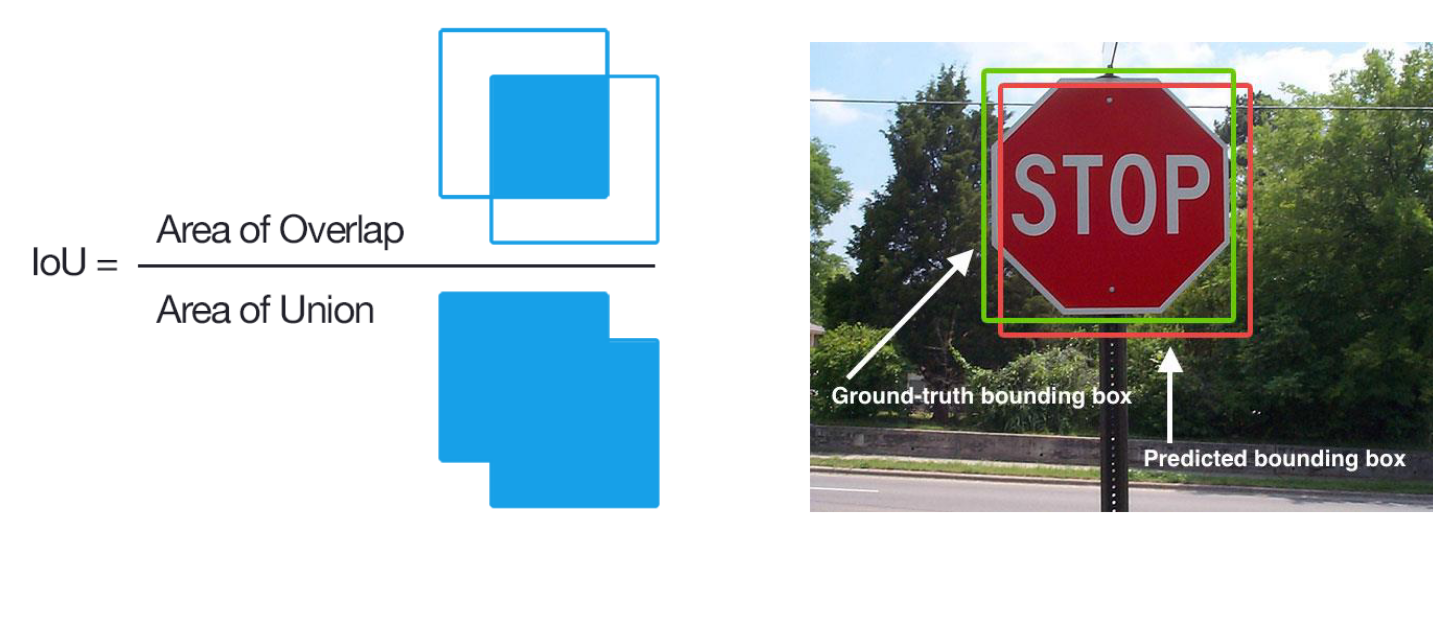

Intersection over Union function takes two boxes as an arguments. Implementing consists from the following steps:
1. Compute coordinates of the intersection box
2. Compute area of the intersection box
3. Compute area of ground truth box and predicted box
4. Compute intersection over union ratio and return it

In [ ]:
def IoU(box1, box2):
  """
  box1: [x1,y1,x2,y2] coordinates of the ground truth box
  box2: [x1,y1,x2,y2] coordinates of the predicted box
  return: IoU between two boxes if they are overlapping, 0 otherwise
  
  with
  x1, y1:  coordinates of the upper left corner
  x2, y2: coordinates of the lower right corner
  """
  # determine coordinates of the intersection
  left_x = max(box1[0], box2[0])
  top_y = min(box1[1], box2[1])
  right_x = min(box1[2], box2[2])
  bottom_y = max(box1[3], box2[3])
  # print(left_x, top_y, right_x, bottom_y)
  # compute intersection area
  interArea = max(0, (right_x - left_x) * (top_y - bottom_y))

  # compute the area of both the prediction and ground-truth
  ground_area = (box1[2] - box1[0]) * (box1[1] - box1[3])
  predicted_area = (box2[2] - box2[0]) * (box2[1] - box2[3])
  # print(interArea, ground_area, predicted_area)
  # compute the IoU
  return interArea / (ground_area + predicted_area - interArea)

## YOLO with OpenCV

To implement non maximum suppression:
1. for every two boxes that are from the same class:
  1. compute IoU for these boxes
  2. if IoU is greater than some threshold then it means that two boxes are overlap, so for the one that has less confidence, reduce it to 0
3. remove boxes for which confidence is equal to 0  


In [ ]:
PATH_TO_YOLO = 'yolo_data/yolo-object-detection/yolo-coco'
CONFIDENCE = 0.5
THRESHOLD = 0.3

class YOLO:
  def __init__(self, PATH_TO_YOLO, CONFIDENCE, THRESHOLD):
    self.CONFIDENCE = CONFIDENCE
    self.THRESHOLD = THRESHOLD
    # load the COCO class labels our YOLO model was trained on
    labelsPath = os.path.sep.join([PATH_TO_YOLO, 'coco.names'])
    self.LABELS = open(labelsPath).read().strip().split("\n")

    # initialize a list of colors to represent each possible class label
    np.random.seed(42)
    self.COLORS = np.random.randint(0, 255, size=(len(self.LABELS), 3),	dtype="uint8")

    # derive the paths to the YOLO weights and model configuration
    weightsPath = os.path.sep.join([PATH_TO_YOLO, "yolov3.weights"])
    configPath = os.path.sep.join([PATH_TO_YOLO, "yolov3.cfg"])

    # load YOLO object detector trained on COCO dataset (80 classes)
    net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
    
    # determine only the *output* layer names that we need from YOLO
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    
    self.net = net
    self.ln = ln
    
  def forward(self, image):
    """
    feed an image to YOLO network, filter weak boxes, 
    return boxes, confidence, class labels
    """
    (H, W) = image.shape[:2]
    # construct a blob from the input image and then perform a forward
    # pass of the YOLO object detector, giving us our bounding boxes and
    # associated probabilities
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    self.net.setInput(blob)
    start = time.time()
    layerOutputs = self.net.forward(self.ln)
    end = time.time()
    
    print("[INFO] YOLO took {:.6f} seconds".format(end - start))
    
    # initialize our lists of detected bounding boxes, confidences, and
    # class IDs, respectively
    boxes = []
    confidences = []
    classIDs = []

    # loop over each of the layer outputs
    for output in layerOutputs:
      # loop over each of the detections
      for detection in output:
        # extract the class ID and confidence
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]

        # filter out weak predictions 
        if confidence > self.CONFIDENCE:
          # scale the bounding box coordinates back relative to the
          # size of the image, keeping in mind that YOLO actually
          # returns the center (x, y)-coordinates of the bounding
          # box followed by the boxes' width and height
          box = detection[0:4] * np.array([W, H, W, H])
          (centerX, centerY, width, height) = box.astype("int")

          # use the center (x, y)-coordinates to derive the top and
          # and left corner of the bounding box
          x = int(centerX - (width / 2))
          y = int(centerY - (height / 2))

          # update our list of bounding box coordinates, confidences,
          # and class IDs
          boxes.append([x, y, int(width), int(height)])
          confidences.append(float(confidence))
          classIDs.append(classID)
          
    self.boxes = np.array(boxes)
    self.confidences = np.array(confidences)
    self.classIDs = np.array(classIDs)
    
  def non_max_supression(self):
    """
    perform non-maximum supression over boxes
    """
    # can be done using cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE, THRESHOLD)
    idxs = np.argsort(-self.confidences)
    confidences = self.confidences[idxs]
    boxes = self.boxes[idxs]
    classIDs = self.classIDs[idxs]

    for i in range(len(boxes)):
      x,y,w,h = boxes[i][0],  boxes[i][1], boxes[i][2], boxes[i][3]
      box1 = [x, y, x+w, y+h]
      for j in range(i+1, len(boxes)):
        # If they are of the same class
        # and have a IoU above self.THRESHOLD
        # we regard them as describing the same object and
        # set the confidence of the box with lower confidence to 0
        if classIDs[i] == classIDs[j]:
          x, y, w, h = boxes[j][0], boxes[j][1], boxes[j][2], boxes[j][3]
          box2 = [x, y, x + w, y + h]
          if IoU(box1, box2) > self.THRESHOLD:
            if confidences[i] > confidences[j]:
              confidences[j] = 0
            else:
              confidences[i] = 0


    idxs = np.where(confidences>0)
    self.boxes = boxes[idxs]
    self.confidences = confidences[idxs]
    self.classIDs = classIDs[idxs]
  
  def detect(self, image):
    """
    detect objects, supress non maximums, draw boxes
    return image with boxes
    """
    self.forward(image)
    self.non_max_supression()
    
    # draw boxes
    for i in range(len(self.boxes)):
      # extract the bounding box coordinates
      (x, y) = (self.boxes[i][0], self.boxes[i][1])
      (w, h) = (self.boxes[i][2], self.boxes[i][3])

      # draw a bounding box rectangle and label on the image
      color = self.COLORS[self.classIDs[i]].tolist()
      cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
      text = "{}: {:.4f}".format(yolo.LABELS[self.classIDs[i]], self.confidences[i])
      cv2.putText(image, text, (x, y + h - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return image
  

## Non-maximum Supression
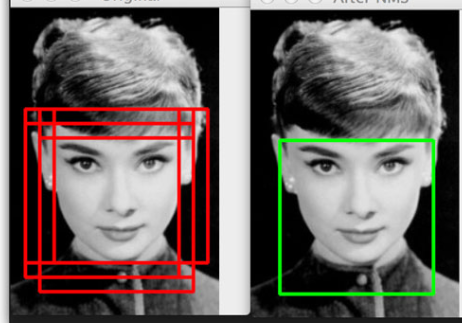

[INFO] YOLO took 1.620470 seconds


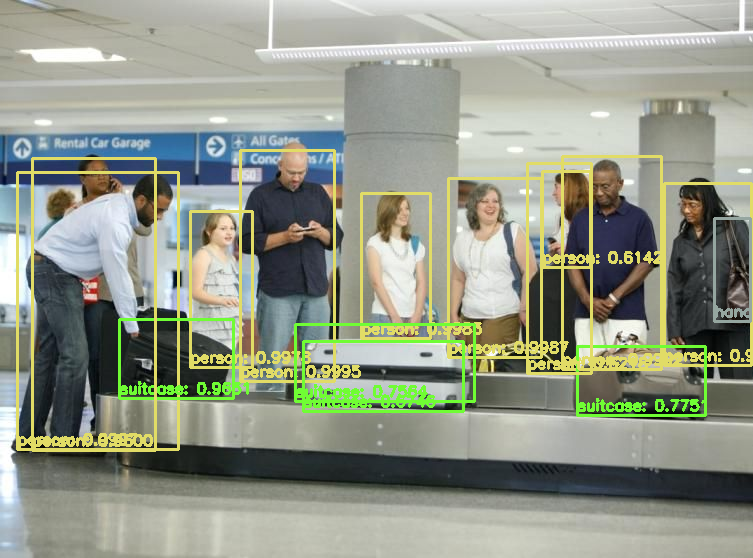

In [ ]:
PATH_TO_IMAGE = 'yolo_data/yolo-object-detection/images/baggage_claim.jpg'
yolo = YOLO(PATH_TO_YOLO, CONFIDENCE, THRESHOLD)  
image = cv2.imread(PATH_TO_IMAGE)
image = yolo.detect(image)
cv2_imshow(image)

[INFO] YOLO took 1.233861 seconds


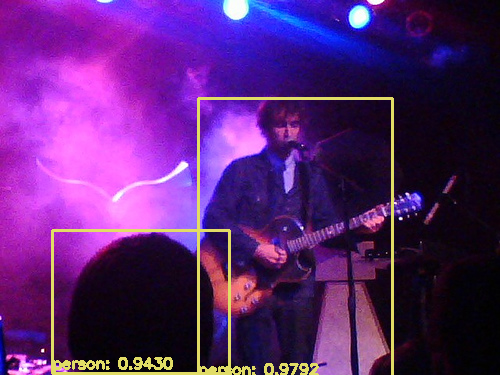

In [ ]:
image = cv2.imread('2012_000160.jpg')
image = yolo.detect(image)
cv2_imshow(image)

[INFO] YOLO took 1.255993 seconds


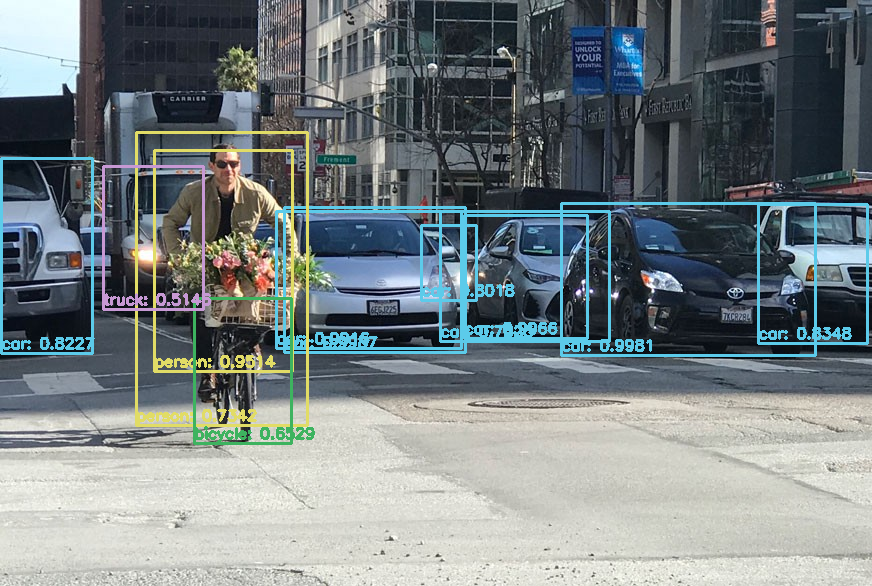

In [ ]:
image = cv2.imread('traffic.jpeg')
image = yolo.detect(image)
cv2_imshow(image)

## Mean Average Precision

In [ ]:
def average_precision(precision, recall):
  AP = 0
  # transform precision
  unique_recall = np.unique(recall)
  for i in range(1, len(unique_recall)):
    r = unique_recall[i]
    idx = np.where(recall == r)
    AP += (r-unique_recall[i-1]) * np.max(precision[idx])
  
  return AP

def mean_average_precision(pred_boxes, ground_truth_boxes):
  MAP = 0
  pred_box, pred_class, pred_confidence = pred_boxes[0], pred_boxes[1], pred_boxes[2]
  gt_box = ground_truth_boxes[0]
  
  # we will calculate AP for each class, hence we need
  # to calculate precision and recall for each class
  AP_class = {}
  
  # first rank predictions by their confidence
  idxs = np.argsort(pred_confidence)
  pred_box, pred_class, pred_confidence = pred_box[idxs], pred_class[idxs], pred_confidence[idxs]
  gt_box = gt_box[idxs]
  
  unique_classes = np.unique(pred_class)
  
  # calculate AP for each class
  for c in unique_classes:
    # take data for that class only
    idxs = np.where(pred_class == c)
    pb_boxes = pred_box[idxs]
    gt_boxes = gt_box[idxs]
    
    TP = FP = 0
    Precision = []
    Recall = []
    
    for pb, gt in zip(pb_boxes, gt_boxes):
      x,y,w,h = pred_box[i][0],  pred_box[i][1], pred_box[i][2], pred_box[i][3]
      box1 = [x-w/2, y+h/2, x+w/2, y-h/2]
      x,y,w,h = gt_box[i][0],  gt_box[i][1], gt_box[i][2], gt_box[i][3]
      box2 = [x-w/2, y+h/2, x+w/2, y-h/2]
      
      if IOU(box1, box2) > 0.5:
          TP =TP+1
      else:
          FP =FP+1    
      try:
          Pre = TP/(TP+FP)
          Rec = TP/len(idxs)
      except ZeroDivisionError:
          Pre = Rec = 0.0
      
      Precision.append(Pre)
      Recall.append(Rec)
      
    # now calculate the AP for that class
    AP = average_precision(Precision, Recall)
    AP_class[c] = AP
    MAP += AP
    

  # now after we computed AP for each class we can calculate MAP 
  return MAP/len(unique_classes)

## References

Original YOLO paper [link](https://arxiv.org/pdf/1506.02640.pdf)

YOLOv2 paper [link](https://arxiv.org/pdf/1612.08242v1.pdf)

YOLOv5 [link](https://ultralytics.com/yolov5)

YOLO explained [link](https://medium.com/@jonathan_hui/real-time-object-detection-with-yolo-yolov2-28b1b93e2088)

IoU [link](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)

Non-Maximum Supression [link](https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/)

Overview of deep learning based object detection approaches [link](https://towardsdatascience.com/beginners-guide-to-object-detection-algorithms-6620fb31c375)

Mean Average Precision [link](https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173)

